Author: Geoff Boeing

Web: http://geoffboeing.com

Description: This notebook visualizes projected location data with matplotlib. More info: http://geoffboeing.com/2014/08/visualizing-summer-travels/

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm
from time import time
from shapely.geometry import Polygon, Point
from geopy.distance import great_circle
from geopandas import GeoDataFrame
from descartes import PolygonPatch

In [2]:
# load the gps coordinate data
# the data files are encoded as utf-8: specify so to prevent matplotlib from choking on diacritics
df = pd.read_csv('data/summer-travel-gps-full.csv', encoding='utf-8')
rs = pd.read_csv('data/summer-travel-gps-dbscan.csv', encoding='utf-8')

In [3]:
# specify the fonts and background color for our map
title_font = fm.FontProperties(family='Bitstream Vera Sans', style='normal', size=15, weight='normal', stretch='normal')
annotation_font = fm.FontProperties(family='Bitstream Vera Sans', style='normal', size=10, weight='normal', stretch='normal')
backgroundcolor = '#e4f4ff'

In [4]:
# load the shapefile
all_countries = GeoDataFrame.from_file('shapefiles/world_borders/TM_WORLD_BORDERS-0.3.shp')

# the original CRS of our shapefile and point data
original_crs = all_countries.crs

# the projected CRS to convert our shapefile and point data into
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}

In [5]:
# change the CRS of the shapefile to the specified projected one
all_countries.to_crs(crs=target_crs, inplace=True)

In [6]:
# create a geometry column in our point data set for geopandas to use
rs['geometry'] = rs.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# create a new geopandas geodataframe from the point data 
points = GeoDataFrame(rs)

# you must specify its original CRS to convert it to a different (projected) one later
points.crs = original_crs
points.head()

,lat,lon,date,city,country,geometry
0,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom,POINT (-0.4460810000000001 51.47819910000001)
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-9.1375444 38.78177460000001)
2,38.771939,-9.128911,05/14/2014 15:41,Lisbon,Portugal,POINT (-9.128910599999999 38.771939)
3,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal,POINT (-9.1477802 38.74298710000001)
4,38.693780,-9.206363,05/15/2014 14:19,Lisbon,Portugal,POINT (-9.206363400000001 38.69377960000001)


In [7]:
# convert the point data to the same projected CRS we specified earlier for our shapefile
points.to_crs(crs=target_crs, inplace=True)

# convert the projected points into discrete x and y columns for easy matplotlib scatterplotting
points['x'] = points['geometry'].map(lambda point: point.x)
points['y'] = points['geometry'].map(lambda point: point.y)    
points.head()

,lat,lon,date,city,country,geometry,x,y
0,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom,POINT (-716600.4651689383 775891.5996303955),-7.166005e+05,775891.599630
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-1634133.575546289 -508480.6745618258),-1.634134e+06,-508480.674562
2,38.771939,-9.128911,05/14/2014 15:41,Lisbon,Portugal,POINT (-1633663.405585119 -509723.5808616227),-1.633663e+06,-509723.580862
3,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal,POINT (-1635993.280910485 -512502.2805595197),-1.635993e+06,-512502.280560
4,38.693780,-9.206363,05/15/2014 14:19,Lisbon,Portugal,POINT (-1642181.7948412 -516694.1408334156),-1.642182e+06,-516694.140833


In [8]:
# calculate some margin so our data doesn't go right up to the edges of the plotting figure
x_margin_width = (points.bounds['maxx'].max() - points.bounds['minx'].min()) / 10
y_margin_width = (points.bounds['maxy'].max() - points.bounds['miny'].min()) / 3

# define the coordinates at the extent of our projected point data
xlim = (points.bounds['minx'].min() - x_margin_width, points.bounds['maxx'].max() + x_margin_width)
ylim = (points.bounds['miny'].min() - y_margin_width, points.bounds['maxy'].max() + y_margin_width)

# create a rectangle from these coordinates
spatial_extent = Polygon([(xlim[0], ylim[0]), 
                          (xlim[0], ylim[1]), 
                          (xlim[1], ylim[1]),
                          (xlim[1], ylim[0])])

In [9]:
# select the country shapes within the spatial extents of our point data
countries = all_countries[all_countries['geometry'].intersects(spatial_extent)]

# set dimensions in inches for the plotting figure size
xdim = (xlim[1] - xlim[0]) / 400000
ydim = (ylim[1] - ylim[0]) / 400000

In [10]:
# get a representative point for each of the most visited cities
most_index = df['city'].value_counts().head(6).index
most = pd.DataFrame(points[points['city'].isin(most_index)])
most.drop_duplicates(subset=['city'], keep='first', inplace=True)
most

,lat,lon,date,city,country,geometry,x,y
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-1634133.575546289 -508480.6745618258),-1.634134e+06,-508480.674562
35,41.387077,2.112232,05/20/2014 15:03,Barcelona,Spain,POINT (-650612.8545010423 -375851.6958494143),-6.506129e+05,-375851.695849
65,50.087729,14.660600,06/02/2014 12:10,Prague,Czech Republic,POINT (329263.3934799764 583235.1809137447),3.292634e+05,583235.180914
98,48.521902,9.055122,06/09/2014 12:12,Tübingen,Germany,POINT (-68815.19792553016 397819.2685319669),-6.881520e+04,397819.268532
149,37.968876,23.728140,07/05/2014 14:05,Athens,Greece,POINT (1192490.978255809 -690612.5656776736),1.192491e+06,-690612.565678
152,40.979387,28.818796,07/06/2014 21:12,Istanbul,Turkey,POINT (1551495.72485398 -274664.5554497115),1.551496e+06,-274664.555450


In [11]:
def get_patches(countries, visited_countries):
    
    # specify the colors for our map
    facecolor = '#f7f7f7'
    visited_facecolor = '#eeeeee'
    edgecolor = '#cccccc'
    
    # create a list to contain a descartes PolygonPatch object for each Polygon in the GeoDataFrame geometry column
    patches = []

    for _, row in countries.iterrows():

        # if this row contains a Polygon object
        if type(row['geometry']) == Polygon:
            fc = visited_facecolor if row['NAME'] in visited_countries else facecolor
            patch = PolygonPatch(row['geometry'], fc=fc, ec=edgecolor, zorder=0)
            patches.append(patch)

        # else, this row contains a MultiPolygon object - this is a shapely object that contains multiple Polygon objects
        # for example, countries that contain islands will have one Polygon shape for their mainland, and others for the island geometries
        else:
            # for each Polygon object in the MultiPolygon
            for polygon in row['geometry']:
                fc = visited_facecolor if row['NAME'] in visited_countries else facecolor
                patch = PolygonPatch(polygon, fc=fc, ec=edgecolor, zorder=0)
                patches.append(patch)
    return patches                

In [12]:
# get a list of visited countries so we can shade those patches a different color
visited_countries = rs['country'].unique()
countries = countries.replace('The former Yugoslav Republic of Macedonia', 'Macedonia (FYROM)')

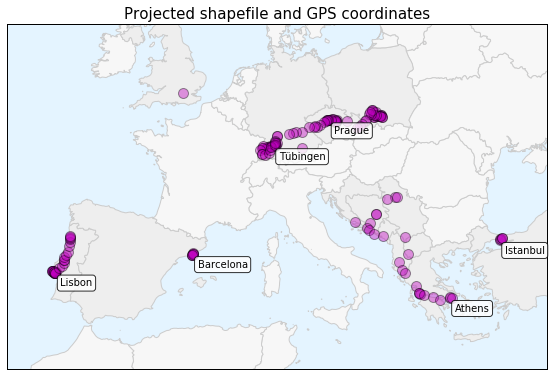

In [13]:
# create a figure, axis, and set the background color
fig = plt.figure(figsize=(xdim, ydim))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor(backgroundcolor)

# add each patch we extracted from the GeoDataFrame's geometry column to the axis
for patch in get_patches(countries, visited_countries):
    ax.add_patch(patch)

# add the projected point data to the axis as a scatter plot
points_scatter = ax.scatter(x=points['x'], y=points['y'], c='m', alpha=0.4, s=100)

ax.set_title('Projected shapefile and GPS coordinates', fontproperties=title_font)

# set the axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# remove the tickmarks as these are projected geometries, the ticks are confusing northings/eastings
ax.set_xticks([])
ax.set_yticks([])

# annotate the most visited cities on the map
for _, row in most.iterrows():
    plt.annotate(row['city'], 
                 xy=(row['x'], row['y']),
                 xytext=(row['x'] + 35000, row['y'] - 100000),
                 bbox=dict(boxstyle='round', color='k', fc='w', alpha=0.8),
                 xycoords='data')

plt.show()

In [14]:
# next we'll identify the most isolated points (or clusters of points, based on some threshold distance) 
# in the projected data set
start_time = time()

# what is the distance to the nearest point that is at least *threshold* miles away?
# ie, ignore all other points within this distance when identifying the next nearest point
# this treats everything within this threshold distance as a single cluster
threshold = 20

# create two new columns in the dataframe of simplified coordinates
# nearest_point will contain the index of the row of the nearest point from the original full data set
# nearest_dist will contain the value of the distance between these two points
points['nearest_point'] = None
points['nearest_dist'] = None

# for each row (aka, coordinate pair) in the data set
for label, row in rs.iterrows():  
    
    point1 = (row['lat'], row['lon'])
    for label2, row2 in rs.iterrows():
        
        # don't compare the row to itself
        if(label != label2):
            
            # calculate the great circle distance between points            
            point2 = (row2['lat'], row2['lon'])
            dist = great_circle(point1, point2).miles

            # if this row's nearest is currently null, save this point as its nearest
            # or if this distance is smaller than the previous smallest, update the row
            if pd.isnull(points.loc[label, 'nearest_dist']) | ((dist > threshold) & (dist < points.loc[label, 'nearest_dist'])):
                points.loc[label, 'nearest_dist'] = dist
                points.loc[label, 'nearest_point'] = label2
            
print 'process took %s seconds' % round(time() - start_time, 2)

process took 13.21 seconds


In [15]:
# sort the points by distance to nearest, then drop duplicates of nearest_point
most_isolated = points.sort_values(by='nearest_dist', ascending=False).drop_duplicates(subset='nearest_point', keep='first')
most_isolated = most_isolated.head(5)

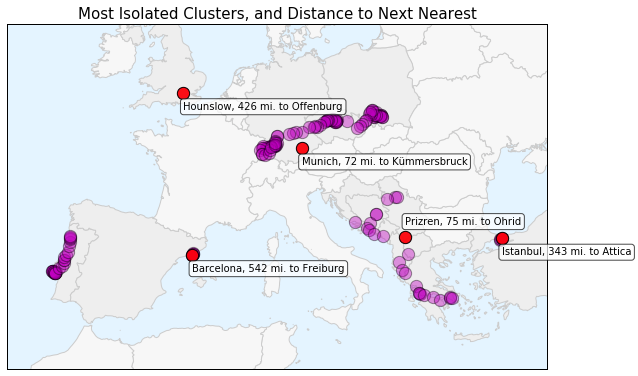

In [16]:
# plot the most isolated clusters in the data set

# create a figure, axis, and set the background color
fig = plt.figure(figsize=(xdim, ydim))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor(backgroundcolor)

# add each patch we extracted from the GeoDataFrame's geometry column to the axis
for patch in get_patches(countries, visited_countries):
    ax.add_patch(patch)

# add the projected point data to the axis as a scatter plot
points_scatter = ax.scatter(points['x'], points['y'], c='m', alpha=.4, s=150)
isolated_scatter = ax.scatter(most_isolated['x'], most_isolated['y'], c='r', alpha=.9, s=150)

ax.set_title('Most Isolated Clusters, and Distance to Next Nearest', fontproperties=title_font)

# set the axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# remove the tickmarks as these are projected geometries, the ticks are confusing northings/eastings
ax.set_xticks([])
ax.set_yticks([])

# annotate each of the most isolated clusters with city name, and distance to next nearest point + its name
for _, row in most_isolated.iterrows():
    xytext = (row['x'], row['y'] - 120000) if row['city'] != 'Prizren' else (row['x'], row['y'] + 90000)
    ax.annotate(row['city'] + ', ' + str(int(row['nearest_dist'])) + ' mi. to ' + rs['city'][row['nearest_point']], 
                xy=(row['x'], row['y']),
                xytext=xytext,
                fontproperties=annotation_font,
                bbox=dict(boxstyle='round', color='k', fc='w', alpha=0.7),
                xycoords='data')

plt.show()